# 1. Import libraries and dataset

In [1]:
!pip install -q medmnist
!pip install -q xgboost scikit-learn matplotlib seaborn opencv-python albumentations scikit-image mahotas scipy imbalanced-learn umap-learn tensorflow pillow tqdm
!mkdir class_task

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 90.1 MB/s eta 0:00:00


In [2]:
import medmnist
from medmnist import INFO, Evaluator, PathMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import imagesize
from collections import defaultdict
import hashlib
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
from collections import Counter
import shutil
import csv
from PIL import Image

In [3]:
!python -m medmnist save --flag=pathmnist --folder=/content/class_task/ --postfix=png --download=True --size=128

Saving pathmnist train...
100% 4.26G/4.26G [12:36<00:00, 5.63MB/s]
Saving train set to /content/class_task/pathmnist_128, csv_path=/content/class_task/pathmnist_128.csv...
100% 89996/89996 [06:35<00:00, 227.36it/s]
Saving pathmnist val...
Saving val set to /content/class_task/pathmnist_128, csv_path=/content/class_task/pathmnist_128.csv...
100% 10004/10004 [00:44<00:00, 227.33it/s]
Saving pathmnist test...
Saving test set to /content/class_task/pathmnist_128, csv_path=/content/class_task/pathmnist_128.csv...
100% 7180/7180 [00:33<00:00, 212.97it/s]


In [3]:
import pprint
pathmnist_info = INFO['pathmnist']
pprint.pprint(pathmnist_info)

{'MD5': 'a8b06965200029087d5bd730944a56c1',
 'MD5_128': 'ac42d08fb904d92c244187169d1fd1d9',
 'MD5_224': '2c51a510bcdc9cf8ddb2af93af1eadec',
 'MD5_64': '55aa9c1e0525abe5a6b9d8343a507616',
 'description': 'The PathMNIST is based on a prior study for predicting '
                'survival from colorectal cancer histology slides, providing a '
                'dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image '
                'patches from hematoxylin & eosin stained histological images, '
                'and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches '
                'from a different clinical center. The dataset is comprised of '
                '9 types of tissues, resulting in a multi-class classification '
                'task. We resize the source images of 3×224×224 into 3×28×28, '
                'and split NCT-CRC-HE-100K into training and validation set '
                'with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test '
                'set.

In [3]:
!mkdir -p /root/.medmnist
!wget -O /root/.medmnist/pathmnist_128.npz https://zenodo.org/records/10519652/files/pathmnist_128.npz?download=1

--2025-07-07 11:01:46--  https://zenodo.org/records/10519652/files/pathmnist_128.npz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4257786775 (4.0G) [application/octet-stream]
Saving to: ‘/root/.medmnist/pathmnist_128.npz’

/root/.medmnist/pat 100%[===================>]   3.96G  3.19MB/s    in 21m 59s 

2025-07-07 11:23:46 (3.08 MB/s) - ‘/root/.medmnist/pathmnist_128.npz’ saved [4257786775/4257786775]



In [4]:
# I will use my Google Drive as a persistent cache
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Upload the dataset to the drive
shutil.copy('/root/.medmnist/pathmnist_128.npz', '/content/drive/MyDrive/aml_project/pathmnist_128.npz')

'/content/drive/MyDrive/aml_project/pathmnist_128.npz'

In [5]:
# Import the dataset from the drive
!mkdir -p /root/.medmnist
!cp /content/drive/MyDrive/aml_project/pathmnist_128.npz /root/.medmnist/pathmnist_128.npz

In [6]:
# OLD

output_dir = "/content/class_task"
os.makedirs(output_dir, exist_ok=True)

class_names = {
    0: "adipose",
    1: "background",
    2: "debris",
    3: "lymphocytes",
    4: "mucus",
    5: "muscle", # smooth muscle
    6: "mucosa", # normal colon mucosa
    7: "cas", # cancer-associated stroma
    8: "adenocarcinoma" # colorectal adenocarcinoma epithelium
}

npz_data = np.load("/root/.medmnist/pathmnist_128.npz")

images = np.concatenate([
    npz_data["train_images"],
    npz_data["val_images"],
    npz_data["test_images"]
], axis=0)

labels = np.concatenate([
    npz_data["train_labels"],
    npz_data["val_labels"],
    npz_data["test_labels"]
], axis=0).flatten()

class_counters = {name: 1 for name in class_names.values()}

csv_path = os.path.join(output_dir, "description.csv")
with open(csv_path, mode="w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["file_name", "file_path", "class"])

    for idx in tqdm(range(len(images)), desc="Exporting images"):
        img_array = images[idx]
        label = int(labels[idx])
        class_name = class_names[label]

        class_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        count = class_counters[class_name]
        class_counters[class_name] += 1

        filename = f"{class_name}_{count:05d}.png"
        file_path = os.path.join(class_name, filename)
        full_save_path = os.path.join(output_dir, file_path)

        Image.fromarray(img_array).save(full_save_path)

        writer.writerow([filename, file_path, class_name])

Exporting images: 100%|██████████| 107180/107180 [00:42<00:00, 2510.08it/s]


# 2. Loading and processing data


Class distribution in the full dataset:
adipose                  : 11745 samples
background               : 11413 samples
debris                   : 11851 samples
lymphocytes              : 12191 samples
mucus                    : 9931 samples
muscle                   : 14128 samples
mucosa                   : 9504 samples
cas                      : 10867 samples
adenocarcinoma           : 15550 samples


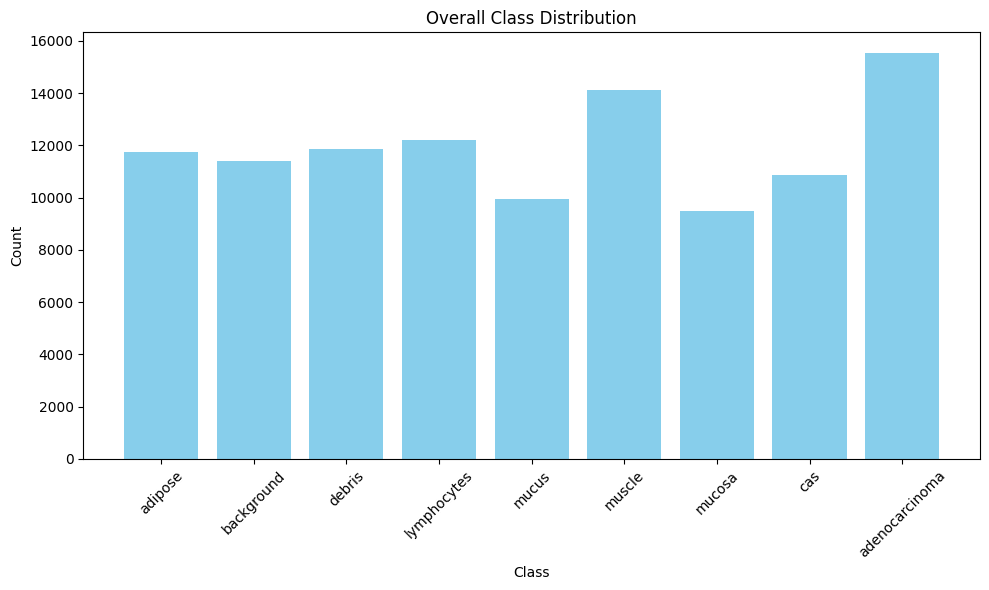


Class distribution in train set:
adipose                  : 9366 samples
background               : 9509 samples
debris                   : 10360 samples
lymphocytes              : 10401 samples
mucus                    : 8006 samples
muscle                   : 12182 samples
mucosa                   : 7886 samples
cas                      : 9401 samples
adenocarcinoma           : 12885 samples


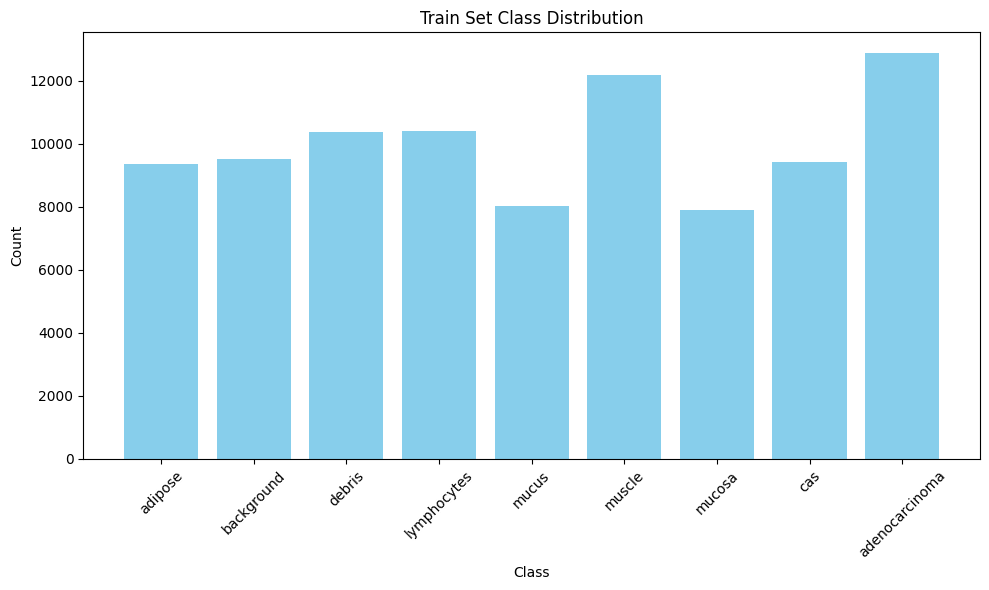


Class distribution in test set:
adipose                  : 1338 samples
background               : 847 samples
debris                   : 339 samples
lymphocytes              : 634 samples
mucus                    : 1035 samples
muscle                   : 592 samples
mucosa                   : 741 samples
cas                      : 421 samples
adenocarcinoma           : 1233 samples


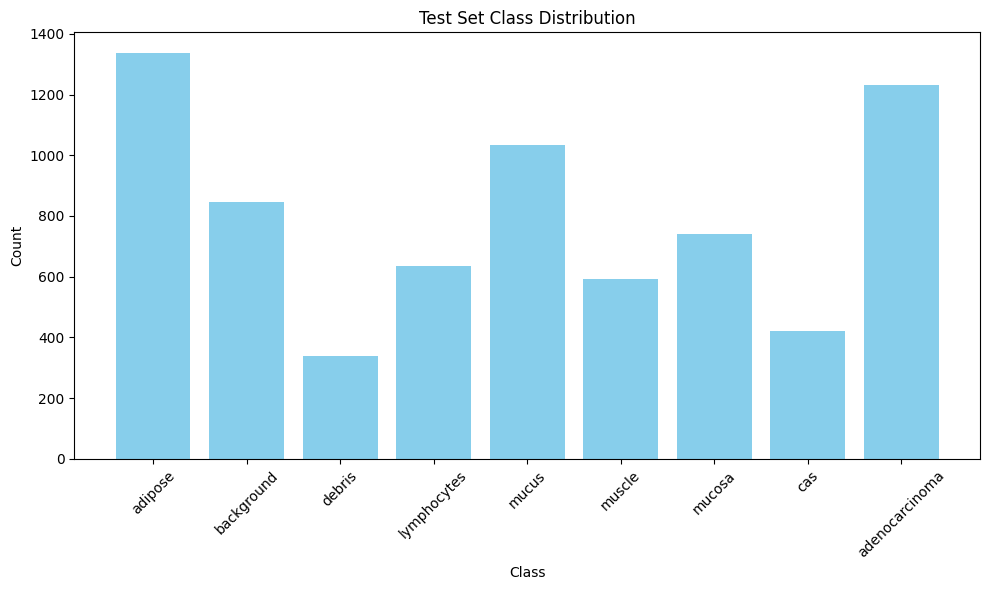


Class distribution in validation set:
adipose                  : 1041 samples
background               : 1057 samples
debris                   : 1152 samples
lymphocytes              : 1156 samples
mucus                    : 890 samples
muscle                   : 1354 samples
mucosa                   : 877 samples
cas                      : 1045 samples
adenocarcinoma           : 1432 samples


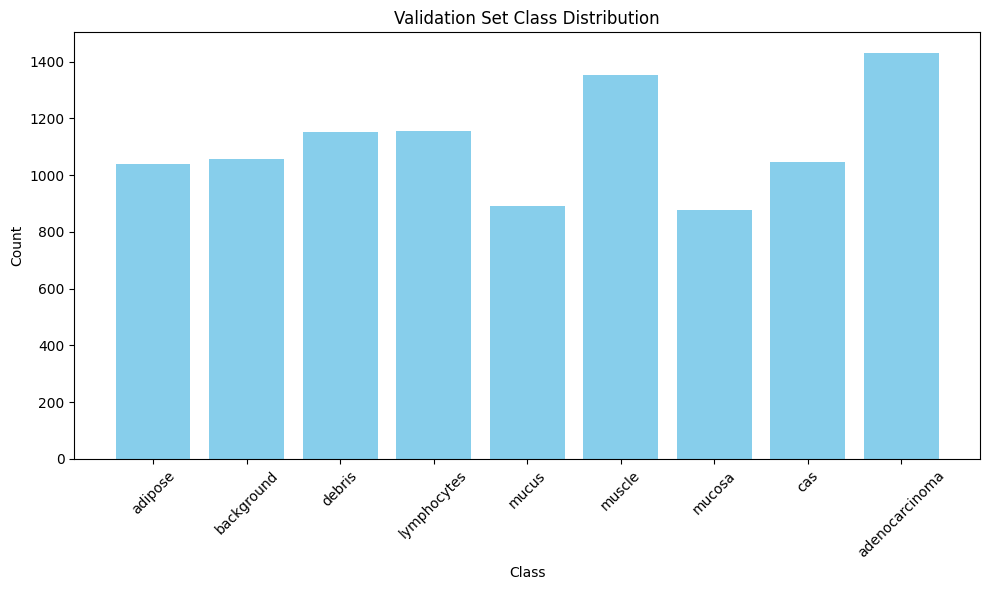

In [8]:
raw_image_metadata = pd.read_csv('/content/class_task/pathmnist_128.csv', header=None, names=['subset', 'filename', 'class'])

class_names = {
    0: "adipose",
    1: "background",
    2: "debris",
    3: "lymphocytes",
    4: "mucus",
    5: "muscle", # smooth muscle
    6: "mucosa", # normal colon mucosa
    7: "cas", # cancer-associated stroma
    8: "adenocarcinoma" # colorectal adenocarcinoma epithelium
}

def compute_class_distribution(dataframe):
    return dict(Counter(dataframe['class']))

def print_distribution(dist_dict, title):
    print(f"\n{title}:")
    for class_idx in sorted(class_names):
        count = dist_dict.get(class_idx, 0)
        print(f"{class_names[class_idx]:25}: {count} samples")

def plot_distribution(dist_dict, title):
    classes = sorted(class_names.keys())
    counts = [dist_dict.get(c, 0) for c in classes]
    labels = [class_names[c] for c in classes]

    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

overall_dist = compute_class_distribution(raw_image_metadata)
print_distribution(overall_dist, "Class distribution in the full dataset")
plot_distribution(overall_dist, "Overall Class Distribution")

train_df = raw_image_metadata[raw_image_metadata['subset'] == 'TRAIN']
train_dist = compute_class_distribution(train_df)
print_distribution(train_dist, "Class distribution in train set")
plot_distribution(train_dist, "Train Set Class Distribution")

test_df = raw_image_metadata[raw_image_metadata['subset'] == 'TEST']
test_dist = compute_class_distribution(test_df)
print_distribution(test_dist, "Class distribution in test set")
plot_distribution(test_dist, "Test Set Class Distribution")

val_df = raw_image_metadata[raw_image_metadata['subset'] == 'VALIDATION']
val_dist = compute_class_distribution(val_df)
print_distribution(val_dist, "Class distribution in validation set")
plot_distribution(val_dist, "Validation Set Class Distribution")

In [25]:
raw_image_metadata = pd.read_csv('description.csv')
print(raw_image_metadata.groupby('class').size())
print(raw_image_metadata.shape)

class
adenocarcinoma    15550
adipose           11745
background        11413
cas               10867
debris            11851
lymphocytes       12191
mucosa             9504
mucus              9931
muscle            14128
dtype: int64
(107180, 3)


100%|██████████| 107180/107180 [00:51<00:00, 2090.24it/s]



Duplicate Analysis:
Total duplicate images found: 0

Duplicates per class:

Detailed duplicate information:

File extension counts:
.jpg: 107180 images


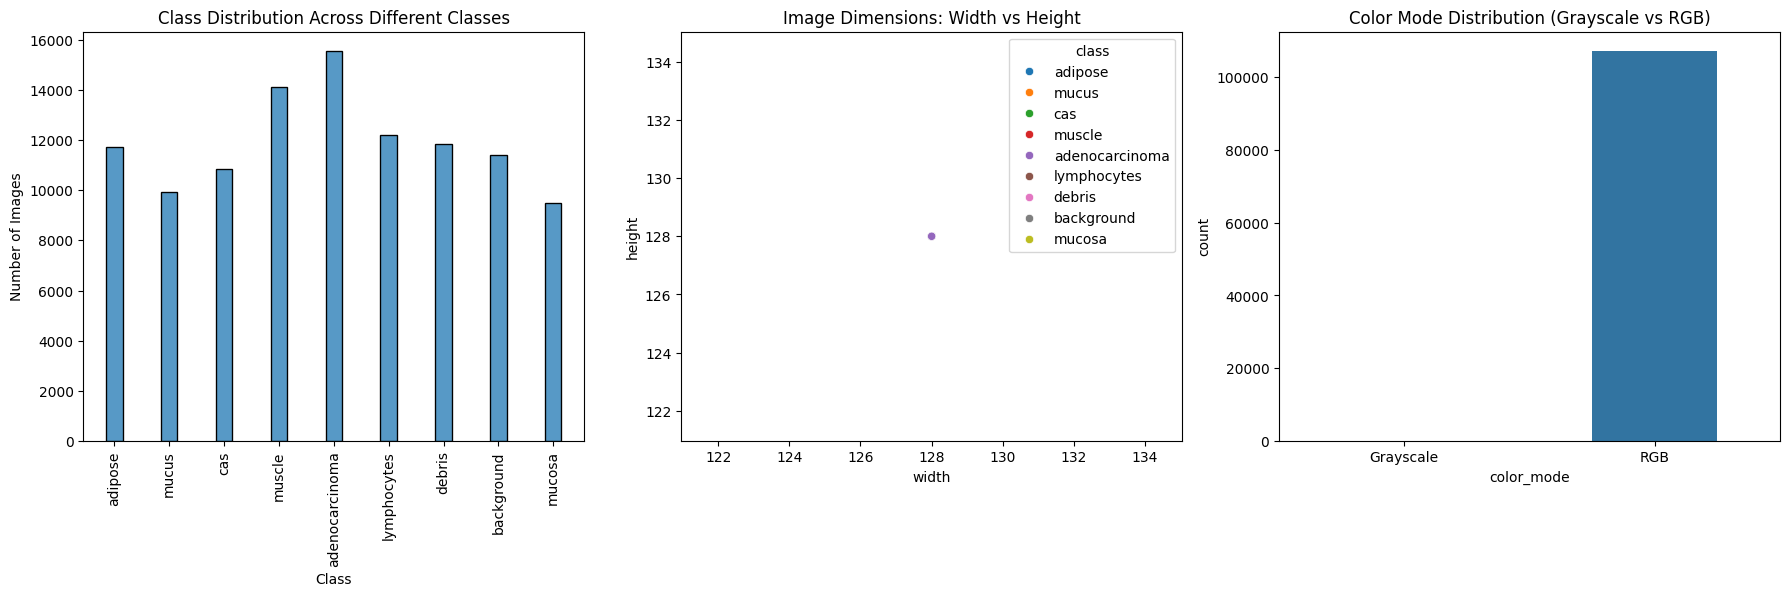

In [26]:
def get_file_hash(filepath):
    """Compute the MD5 hash of the image file."""
    with open(filepath, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

def get_image_metadata_from_df(df):
    """Collects metadata for images and handles duplicates properly."""
    ext_count = defaultdict(int)
    unique_hashes = {}
    duplicates = defaultdict(list)

    df['file_path'] = df['file_path'].str.replace("\\", "/")
    df['original_extension'] = ''
    df['width'] = 0
    df['height'] = 0
    df['aspect_ratio'] = 0.0
    df['color_mode'] = ''
    df['is_duplicate'] = False
    df['original_index'] = None

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        filename = row['file_name']
        img_path = row['file_path']
        class_name = row['class']

        img_hash = get_file_hash(img_path)

        if img_hash in unique_hashes:
            df.at[idx, 'is_duplicate'] = True
            df.at[idx, 'original_index'] = unique_hashes[img_hash]
            duplicates[class_name].append({
                'duplicate_idx': idx,
                'original_idx': unique_hashes[img_hash],
                'hash': img_hash
            })
            continue

        unique_hashes[img_hash] = idx

        width, height = imagesize.get(img_path)
        img = Image.open(img_path)
        color_mode = "RGB" if img.mode == "RGB" else "Grayscale"

        ext = os.path.splitext(filename)[1].lower()
        ext_count[ext] += 1

        df.at[idx, 'original_extension'] = ext
        df.at[idx, 'width'] = width
        df.at[idx, 'height'] = height
        df.at[idx, 'aspect_ratio'] = round(width / height, 2)
        df.at[idx, 'color_mode'] = color_mode

    duplicate_summary = {
        'total_duplicates': df['is_duplicate'].sum(),
        'duplicates_per_class': {class_name: len(dupes) for class_name, dupes in duplicates.items()},
        'detailed_duplicates': duplicates
    }

    df_clean = df[~df['is_duplicate']].copy()
    df_clean.reset_index(drop=True, inplace=True)

    return df_clean, ext_count, duplicate_summary

def display_duplicate_info(duplicate_summary):
    """Display detailed information about duplicates"""
    print("\nDuplicate Analysis:")
    print(f"Total duplicate images found: {duplicate_summary['total_duplicates']}")

    print("\nDuplicates per class:")
    for class_name, count in duplicate_summary['duplicates_per_class'].items():
        if count > 0:
            print(f"Class '{class_name}': {count} duplicates")

    print("\nDetailed duplicate information:")
    for class_name, dupes in duplicate_summary['detailed_duplicates'].items():
        if dupes:
            print(f"\nClass: {class_name}")
            for dupe in dupes:
                print(f"  Duplicate at index {dupe['duplicate_idx']} is a copy of image at index {dupe['original_idx']}")

def display_info(img_meta_df, ext_count):
    print("\nFile extension counts:")
    for ext, count in ext_count.items():
        print(f"{ext}: {count} images")

    fig = plt.figure(figsize=(18, 16))
    gs = fig.add_gridspec(3, 3)

    # 1. Class distribution plot
    ax1 = fig.add_subplot(gs[0, 0])
    sns.histplot(img_meta_df, x='class', multiple='dodge', binwidth=0.3, shrink=0.3, kde=False, legend=True, ax=ax1)
    ax1.set_title("Class Distribution Across Different Classes")
    ax1.set_xlabel("Class")
    ax1.set_ylabel("Number of Images")
    ax1.tick_params(axis='x', rotation=90)

    # 2. Scatter plot: Width vs Height
    ax2 = fig.add_subplot(gs[0, 1])
    sns.scatterplot(x="width", y="height", hue="class", data=img_meta_df, ax=ax2)
    ax2.set_title("Image Dimensions: Width vs Height")

    # 3. Histogram of Color Modes
    ax3 = fig.add_subplot(gs[0, 2])
    img_meta_df['color_mode'] = pd.Categorical(img_meta_df['color_mode'], categories=["Grayscale", "RGB"])
    sns.countplot(x="color_mode", data=img_meta_df, ax=ax3, width=0.5)
    ax3.set_title("Color Mode Distribution (Grayscale vs RGB)")

    plt.tight_layout()
    plt.show()

clean_image_metadata, ext_count, duplicate_summary = get_image_metadata_from_df(raw_image_metadata)

# duplicate information
display_duplicate_info(duplicate_summary)

clean_image_metadata.to_csv('clean_image_metadata.csv', index=False)

# other info
display_info(clean_image_metadata, ext_count)

#  OLD CODE

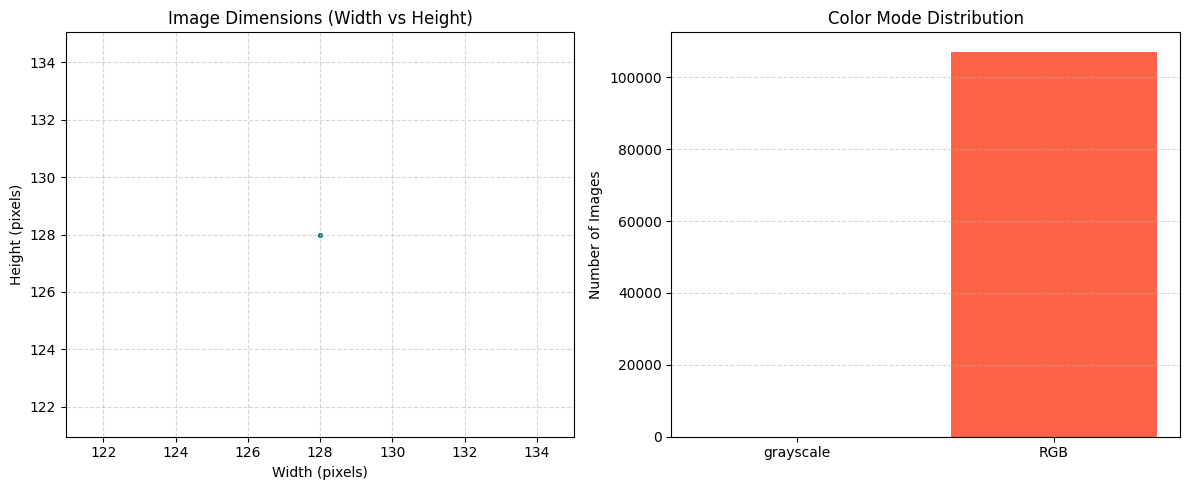

In [6]:
all_images = np.concatenate([train_dataset.imgs, val_dataset.imgs, test_dataset.imgs], axis=0)  # shape: (N, H, W, C)

heights = [img.shape[0] for img in all_images]
widths  = [img.shape[1] for img in all_images]

color_modes = {"grayscale": 0, "RGB": 0}
for img in all_images:
    if img.shape[-1] == 1:
        color_modes["grayscale"] += 1
    elif img.shape[-1] == 3:
        color_modes["RGB"] += 1

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Image Dimensions
axes[0].scatter(widths, heights, alpha=0.3, color="teal", s=2)
axes[0].set_title("Image Dimensions (Width vs Height)")
axes[0].set_xlabel("Width (pixels)")
axes[0].set_ylabel("Height (pixels)")
axes[0].grid(True, linestyle="--", alpha=0.5)

# Color Mode Distribution
axes[1].bar(color_modes.keys(), color_modes.values(), color=['gray', 'tomato'])
axes[1].set_title("Color Mode Distribution")
axes[1].set_ylabel("Number of Images")
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from torchvision.transforms import (RandomHorizontalFlip, RandomVerticalFlip,
                                    RandomRotation, ColorJitter)
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import random
from skimage import io, img_as_ubyte
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.measure import shannon_entropy
from skimage.filters import sobel, gabor
from skimage.color import rgb2gray
import mahotas
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, label_binarize
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
import umap
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.tree import DecisionTreeClassifier
from torch.utils.data import Dataset
import torch

RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)